<a href="https://colab.research.google.com/github/divyanshu-krs/hmi/blob/master/derm-foundation/derm_foundation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Google-Health/imaging-research/blob/master/derm-foundation/derm_foundation_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Google-Health/imaging-research/tree/master/derm-foundation"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Derm Foundation API Demo

The ipynb is a demonstration of using the
[Derm Foundation API](https://github.com/Google-Health/imaging-research/tree/master/derm-foundation)
(this API computes embeddings for dermatology-related images).

The contents include how to:

-   Load a dataset from a CSV and image files stored in GCS
-   Generate embeddings for the image files
-   Train a small model using the embeddings

**Note**: It can take some time to generate embeddings for thousands of images.
For ease of use, by default, this colab uses precomputed embeddings. You can
also calculate them from scratch again by updating the relevant param in the
"Global params" section.

### This notebook is for API demonstration purposes only

**Note: This notebook is for API demonstration purposes only.**

Because the PAD dataset is publicly available online, it's possible that some of
this data has "leaked" into training dataset used for the model underlying the
Derm Foundation API.

Additionally, it's critical in dermatology use-cases to use evaluation datasets
that reflect the expected distribution of users (in particular for skin tone,
age, and gender). This dataset's distribution is unlikely to match most
populations.

This means that the best way to determine if this API is right for you is to try it with data that would be used for the downstream task you're interested in.

## Prerequisites

You must have access to the Dermatology Foundation API. See the project's
[README](https://github.com/Google-Health/imaging-research/blob/master/derm-foundation/README.md)
for details.

## Setup

In [1]:
#@title Install the required packages

!pip install matplotlib tf-models-official>=2.13.0 google-cloud-storage tqdm

In [2]:
# @title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
from typing import List, Text
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tabulate
import tensorflow as tf

In [3]:
# @title Global params


class Globals:
  # @markdown GCP project with GCS bucket of interest:
  gcp_project = 'hai-cd3-foundations'  # @param

  # GCS bucket with data to read:
  gcs_bucket_name = 'hai-cd3-foundations-dermatology'  # @param

  # @markdown PAD Dataset files:
  # Metadata CSV from PAD dataset to read
  gcs_metadata_csv = 'pad_dataset/metadata.csv'  # @param

  # Images directory:
  gcs_images_dir = 'pad_dataset/images/'  # @param

  # Column name to use for the small model
  label_column = 'diagnostic'  # @param

  # Column to join the CSV to the images by path
  img_join_column = 'img_id' # @param

  # @markdown If precomputed embeddings should be used:
  # When true, use precomputed embeddings instead of generating
  # from scratch.
  gcs_use_precomputed_embeddings = True  # @param {type: "boolean"}

  # Path to precomputed embeddings
  gcs_precomputed_embeddings = 'pad_dataset/precomputed/embeddings.npz'  # @param

  # Access Token for `gcs_bucket_name`.
  # Note: You can also manually create and set this
  #   by using `gcloud auth print-access-token` in your local
  #   environment.
  gcs_creds = None

  # @markdown ---
  # @markdown Vertex AI end-point configuration:
  vertex_endpoint_project_id = '132886652110'  # @param
  vertex_endpoint_id = '180'  # @param
  vertex_endpoint_location = 'us-central1'  # @param

  random_state = 3141
  embeddings_size = 6144
  # @markdown ---
  # @markdown Training Parameters--Adjust this to reduce or increase the training size as a % of total training:
  train_split_size = 0.15 # @param
  # Note: this variable sets the training split. We set it by default to 0.15 to show how effective the model is on a small amount of data. You can increase it to see how more data improves the accuracy.

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  metadata_df = None

  # Dict from image path -> embedding
  embeddings = dict()

  # pd.DataFrames for training/validation data splits
  df_train = None
  df_validate = None

  # ML model
  model = None

### Authenticate

The following cell is for Colab only. If running elsewhere, authenticate with
the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

**WARNING**: The colab auth cell below will result in a pop-up asking you to
enable access. This enables the notebook to interact with all GCP projects you
have access to on your behalf.

In [4]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [5]:
import datetime
import google.auth
import google.auth.transport.requests

Globals.gcs_creds, project = google.auth.default()


def initial_token_refresh():
  # Refresh credentials so an access token is available.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)
  assert (
      Globals.gcs_creds.valid
  ), f'Unexpected error: GCS Credentials are invalid'
  time_until_expiry = (
      Globals.gcs_creds.expiry - datetime.datetime.utcnow()
  ).total_seconds() // 60
  print(
      'Token will expire at'
      f' {Globals.gcs_creds.expiry.strftime("%Y-%m-%d %H:%M:%S")} UTC'
      f' ({time_until_expiry} minutes)'
  )


initial_token_refresh()

Token will expire at 2025-03-13 12:06:12 UTC (59.0 minutes)


## Load PAD-UFES-20 dataset

This colab uses the
[PAD-UFES-20 dataset](https://data.mendeley.com/datasets/zr7vgbcyr2/1), which
contains 2,298 images of 6 skin conditions from 1,373 patients in Brazil.

Condition list:

*   Basal Cell Carcinoma (BCC)
*   Squamous Cell Carcinoma (SCC)
*   Actinic Keratosis (ACK)
*   Seborrheic Keratosis (SEK)
*   Bowen's disease (BOD)
*   Melanoma (MEL)
*   Nevus (NEV)

**NOTE**: Any work that uses this dataset must abide by the restrictions and
citation requirements listed on
[their website](https://data.mendeley.com/datasets/zr7vgbcyr2/1).

**Dataset citation**: Pacheco, Andre G. C.; Lima, Gustavo R.; Salomão, Amanda
S.; Krohling, Breno; Biral, Igor P.; de Angelo, Gabriel G. ; Alves Jr, Fábio C.
R. ; Esgario, José G. M.; Simora, Alana C. ; Castro, Pedro B. C. ; Rodrigues,
Felipe B.; Frasson, Patricia H. L. ; Krohling, Renato A.; Knidel, Helder ;
Santos, Maria C. S. ; Espírito Santo, Rachel B.; Macedo, Telma L. S. G.; Canuto,
Tania R. P. ; de Barros, Luíz F. S. (2020), “PAD-UFES-20: a skin lesion dataset
composed of patient data and clinical images collected from smartphones”,
Mendeley Data, V1, doi: 10.17632/zr7vgbcyr2.1

In [6]:
from google.cloud import storage


def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)


def load_dataset(bucket, csv_path, images_dir):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()))
  df['img_path'] = df[Globals.img_join_column].apply(lambda x: os.path.join(images_dir, x))
  return df


Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
list_blobs(Globals.gcs_storage_client, Globals.gcs_bucket_name)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(Globals.gcs_bucket_name)
Globals.metadata_df = load_dataset(
    Globals.gcs_bucket, Globals.gcs_metadata_csv, Globals.gcs_images_dir
)
Globals.all_col_vals = sorted(set(Globals.metadata_df[Globals.label_column]))

<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1000_31_620.png, 1702661991082313>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1006_53_385.png, 1702661999624888>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1006_53_716.png, 1702661991059016>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1008_59_297.png, 1702661999655579>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_100_393_595.png, 1702661999638420>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_100_393_898.png, 1702661991100580>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1013_82_876.png, 1702661999619913>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1014_85_22.png, 1702661991125509>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1014_86_861.png, 1702661999630893>
<Blob: hai-cd3-foundations-dermatology, pad_dataset/images/PAT_1017_97_577.png, 1702661999629368>
<Blob: hai-cd3-founda

In [10]:
Globals.metadata_df

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,img_path
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False,pad_dataset/images/PAT_1516_1765_530.png
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True,pad_dataset/images/PAT_46_881_939.png
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False,pad_dataset/images/PAT_1545_1867_547.png
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False,pad_dataset/images/PAT_1989_4061_934.png
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True,pad_dataset/images/PAT_684_1302_588.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False,pad_dataset/images/PAT_1708_3156_175.png
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True,pad_dataset/images/PAT_46_880_140.png
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,...,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False,pad_dataset/images/PAT_1343_1217_404.png
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,...,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True,pad_dataset/images/PAT_326_690_823.png


In [11]:
# @title Print interesting metadata
def print_metadata_stats(metadata_df: pd.DataFrame) -> None:
  print(f'Num Patients: {len(metadata_df)}')
  print('Column Names:')
  for column in metadata_df.columns:
    print(f'  {column}')
  print(
      f'Column values for "{Globals.label_column}":'
      f' {sorted(set(metadata_df[Globals.label_column]))}'
  )


print_metadata_stats(Globals.metadata_df)

Num Patients: 2298
Column Names:
  patient_id
  lesion_id
  smoke
  drink
  background_father
  background_mother
  age
  pesticide
  gender
  skin_cancer_history
  cancer_history
  has_piped_water
  has_sewage_system
  fitspatrick
  region
  diameter_1
  diameter_2
  diagnostic
  itch
  grew
  hurt
  changed
  bleed
  elevation
  img_id
  biopsed
  img_path
Column values for "diagnostic": ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']


There are a total of 2298 images. We will sample 3 to display.
Image 1867


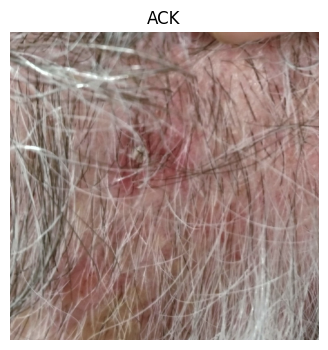

Image 506


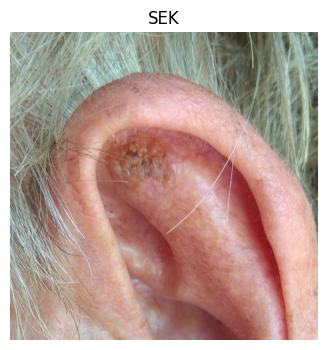

Image 443


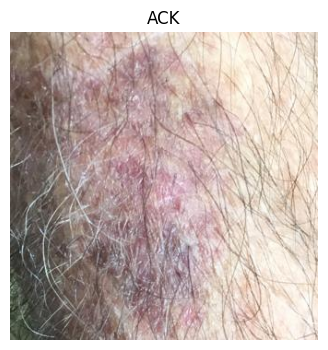

In [12]:
# @title Display image sample
import io
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def display_image(bucket, image_path, title):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size = 4
  f, axarr = plt.subplots(1, 1, figsize=(figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  axarr.set_title(title)
  plt.show()


def display_images(df, bucket, file_to_visualize=3):
  max_index = len(df['img_path'].values)
  print(
      f'There are a total of {max_index} images. '
      f'We will sample {file_to_visualize} to display.'
  )
  list_of_images = random.sample(range(0, max_index - 1), file_to_visualize)
  for image_idx in list_of_images:
    filename = df['img_path'].values[image_idx]
    diagnostic = df['diagnostic'].values[image_idx]
    print('Image %d' % image_idx)
    display_image(bucket, filename, title=diagnostic)


display_images(Globals.metadata_df, Globals.gcs_bucket)

## Load Pre-computed Embeddings

This section loads pre-computed embeddings. To regenerate them, see the
'Generate Embeddings' section below

In [13]:
# @title Helper: Save/load embeddings via numpy.savez


def convert_to_numpy_dict(embeddings):
  updated_embeddings = {}
  for filepath, embedding in embeddings.items():
    updated_embeddings[filepath] = np.array(embedding)
  return updated_embeddings


def save_embeddings_to_file(
    project_name, bucket_name, object_name, embeddings=None
):
  gcs_storage_client = storage.Client(project_name)
  bucket = gcs_storage_client.bucket(bucket_name)
  blob = bucket.blob(object_name)
  data_dict = embeddings or convert_to_numpy_dict(Globals.embeddings)
  type(data_dict)
  try:
    with blob.open('wb', ignore_flush=True) as f:
      np.savez(f, **data_dict)
  except Exception as e:
    print(f'Saving embeddings failed: {e}')
    raise


def load_embeddings_from_file(project_name, bucket_name, object_name):
  gcs_storage_client = storage.Client(project_name)
  bucket = gcs_storage_client.bucket(bucket_name)
  blob = bucket.blob(object_name)
  embeddings = dict()
  with blob.open('rb') as f:
    x = np.load(f)
    for k, v in x.items():
      embeddings[k] = v
  return embeddings

In [14]:
#@title Load embeddings
%%time
if Globals.gcs_use_precomputed_embeddings:
  err_msg = ('A path to precomputed_embeddings must be set when '
             '`gcs_use_precomputed_embeddings` is set. Found '
            f'{Globals.gcs_precomputed_embeddings}')
  assert Globals.gcs_precomputed_embeddings, err_msg
  Globals.embeddings = load_embeddings_from_file(
      Globals.gcp_project,
      Globals.gcs_bucket_name,
      Globals.gcs_precomputed_embeddings)
print(f'Loaded {len(Globals.embeddings)} embeddings.')

Loaded 2298 embeddings.
CPU times: user 1.43 s, sys: 698 ms, total: 2.13 s
Wall time: 5.45 s


## Generate Embeddings

**IMPORTANT**: You must have access to the Dermatology Foundation API. See the
project's
[README](https://github.com/Google-Health/imaging-research/blob/master/derm-foundation/README.md)
for details.

**NOTE**: This takes a long time (~hours) to run for a lot of images.

In [15]:
# @title Helpers: call Vertex predict
from typing import List
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf import struct_pb2

PredictionServiceClient = aiplatform.gapic.PredictionServiceClient


def create_prediction_service_client_and_endpoint_path():
  client_options = {
      'api_endpoint': (
          f'{Globals.vertex_endpoint_location}-aiplatform.googleapis.com'
      )
  }
  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple
  # requests.
  client = PredictionServiceClient(client_options=client_options)
  endpoint_path = client.endpoint_path(
      project=Globals.vertex_endpoint_project_id,
      location=Globals.vertex_endpoint_location,
      endpoint=Globals.vertex_endpoint_id,
  )
  return client, endpoint_path


def get_prediction_instances(image_uris: List[str]):
  """Returns a list of JSON dicts to pass as Vertex PredictionService instances."""
  instances = []
  for image_uri in image_uris:
    instance_dict = {
        'bucket_name': Globals.gcs_bucket_name,
        'object_uri': image_uri,
        'bearer_token': Globals.gcs_creds.token,
    }
    instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
    instances.append(instance)
  return instances


def predict(
    client: PredictionServiceClient, endpoint_path: str, image_uris: List[str]
):
  """Calls predict for a Vertex endpoint using the given image paths."""
  instances = get_prediction_instances(image_uris)
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

In [16]:
%%time
#@title Example predict request
def run_single_predict_request(bucket_name, object_uri):
  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  assert Globals.gcs_creds.token, 'GCS Credential token is not valid. Re-run "Authenticate" section?'
  instance_dict = {
      'bucket_name': bucket_name,
      'object_uri': object_uri,
      'bearer_token': Globals.gcs_creds.token,
  }
  instance = json_format.ParseDict(instance_dict, struct_pb2.Value())
  instances = [instance]
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, struct_pb2.Value())

  return client.predict(
      endpoint=endpoint_path, instances=instances, parameters=parameters
  )

# Example of how to run:
TEST_PREDICT_VAL = run_single_predict_request(
    bucket_name=Globals.gcs_bucket_name,
    object_uri='pad_dataset/images/PAT_1516_1765_530.png')

# Note: The embedding is in TEST_PREDICT_VAL.predictions
print(TEST_PREDICT_VAL.deployed_model_id)
print(TEST_PREDICT_VAL.model)
print(TEST_PREDICT_VAL.model_display_name)
print(TEST_PREDICT_VAL.model_version_id)

8807129919927615488
projects/132886652110/locations/us-central1/models/dermatology
dermatology
5
CPU times: user 214 ms, sys: 41 ms, total: 255 ms
Wall time: 41.5 s


In [17]:
if Globals.gcs_use_precomputed_embeddings:
  # Check that the embeddings match.
  precomputed = Globals.embeddings['pad_dataset/images/PAT_1516_1765_530.png']
  assert len(precomputed) == len(TEST_PREDICT_VAL.predictions[0]), (
      f'Expected equal lengths: {len(precomputed)} !='
      f' {len(TEST_PREDICT_VAL.predictions[0])}'
  )
  print(f'First 10 items of the `precomputed` list:')
  print(precomputed[:10])
  print(f'First 10 items of the embedding from the above API call:')
  print(list(TEST_PREDICT_VAL.predictions[0])[:10])
  print('Asserting that the lists are equal:')
  assert list(precomputed) == TEST_PREDICT_VAL.predictions[0]

First 10 items of the `precomputed` list:
[0.         0.         0.00623926 2.64813972 0.         0.
 0.16615391 0.13472241 0.09618477 0.24233027]
First 10 items of the embedding from the above API call:
[0.0, 0.0, 0.00623926288, 2.64813972, 0.0, 0.0, 0.166153908, 0.134722412, 0.0961847678, 0.242330268]
Asserting that the lists are equal:


In [18]:
BATCH_COUNTER = collections.Counter()

In [19]:
#@title Generate embeddings concurrently
%%time
import concurrent.futures
import time

def refresh_credentials():
  # Refreshing is required b/c this can take longer than the typical 1-hr
  # timeout.
  auth_req = google.auth.transport.requests.Request()
  Globals.gcs_creds.refresh(auth_req)

def run_predict(client, endpoint_path, img_paths, batch_id=None):
  # Ensure the GCS token has not yet expired. Otherwise `predict`
  # returns `500 Internal Error`.
  if not Globals.gcs_creds.valid:
    refresh_credentials()
    if not Globals.gcs_creds.valid:
      print('GCP Credentials are not valid.')
      return (None, None)
  start = time.time()
  try:
    predictions = predict(client, endpoint_path, img_paths)
  except Exception as e:
    print(f'Error generating embedding for {img_paths}: {e}')
    return (None, None)

  end = time.time()
  return (zip(img_paths, predictions.predictions), end-start, batch_id)


def generate_embeddings_concurrently(df, batch_size=1, num_workers=5):
  """Calls the API to compute embeddings for all images with no embedding yet."""
  # Generate batches of image paths to run the `predict` function with
  all_path_args = []
  for batch_start in np.arange(0, len(df), batch_size):
    batch_df = df.iloc[batch_start:batch_start+batch_size]
    img_paths = list(batch_df['img_path'])
    skip_iteration = True
    for img_path in img_paths:
      if img_path not in Globals.embeddings:
        skip_iteration = False
        break
    if skip_iteration:
      print(f'(skipped) {batch_start}')
      continue
    all_path_args.append(img_paths)

  client, endpoint_path = create_prediction_service_client_and_endpoint_path()
  total_embeddings = 0

  # Concurrently run `predict` requests for all image paths.
  overall_start = time.time()
  batch_counter = collections.Counter()
  with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(run_predict, client, endpoint_path, arg, batch_id=i) for i, arg in enumerate(all_path_args)]
    for future in concurrent.futures.as_completed(futures):
      preds, batch_time, batch_id = future.result()
      if preds is not None:
        print(f'{batch_id}: {batch_time}')
        batch_counter[int(batch_time)] += 1
        BATCH_COUNTER[int(batch_time)] += 1
        for img_path, pred in preds:
          Globals.embeddings[img_path] = pred
          total_embeddings += 1
  overall_end = time.time()
  print(f'Total embeddings retrieved: {total_embeddings}')
  print(f'Total time: {overall_end-overall_start}s ({overall_end-overall_start/60.0:.1f})')
  return batch_counter

REQUEST_TIMES = None
if Globals.gcs_use_precomputed_embeddings:
  print(f'WARNING: Skipping calculating embeddings. Precomputed embeddings will be used instead.')
if not Globals.gcs_use_precomputed_embeddings:
  # Note: You can scale up the number of workers after ~10m of making a high
  # volume of API calls.
  REQUEST_TIMES = generate_embeddings_concurrently(Globals.metadata_df)

CPU times: user 79 µs, sys: 0 ns, total: 79 µs
Wall time: 86.5 µs


In [20]:
print(len(Globals.embeddings))

2298


In [21]:
for batch_time in sorted(BATCH_COUNTER):
  print(f'{batch_time}: {BATCH_COUNTER[batch_time]}')

## Prepare training data

In [22]:
# Check that we have an embedding for every image
if len(Globals.embeddings) < len(Globals.metadata_df):
  raise ValueError(
      f'Expected {len(Globals.metadata_df)} embeddings to be present. '
      f'Got {len(Globals.embeddings)}.\n'
      'Maybe the "Generate embeddings" cell should be run again? This can '
      'happen if there are intermittent API errors.'
  )

In [23]:
# @title Split data into train and validate

from sklearn import model_selection


def make_split(df, train_size=0.3):
  """Splits the dataframe into meaningful train/test sets.

  Note: This function attempts to have the condition distributions between train
  and test sets match (important because of significant class imbalance) and
  to have no overlapping patients (important to avoid data leakage).
  """
  gss = model_selection.GroupShuffleSplit(
      n_splits=1, train_size=train_size, random_state=Globals.random_state
  )
  train = None
  val = None
  for i, (train_index, test_index) in enumerate(
      gss.split(df, df[Globals.label_column], groups=df['patient_id'])
  ):
    train = df.iloc[train_index]
    val = df.iloc[test_index]
  print(
      f'Generated train split of length {len(train)} and validation split of'
      f' length {len(val)}'
  )
  return train, val


# Select a smaller portion of the data for training for demo purposes
Globals.df_train, Globals.df_validate = make_split(
    Globals.metadata_df, train_size=Globals.train_split_size
)

Generated train split of length 332 and validation split of length 1966


In [24]:
def print_column_distribution_info(df, label_column):
  c = collections.Counter(df[label_column])
  total = sum(c.values())
  warnings = []
  for i in sorted(c.keys()):
    v = c[i]
    print(f'  {i} {v}/{total} ({100.0*v/total:.0f}%)')
    if v < 20:
      warnings.append(
          f'Less than 20 examples found for {i} ({v} examples). '
          'It will be difficult to learn from or evaluate so few examples!'
      )
  print('\n'.join(warnings))


print('df_train:')
print_column_distribution_info(
    Globals.df_train, label_column=Globals.label_column
)
print('df_validate:')
print_column_distribution_info(
    Globals.df_validate, label_column=Globals.label_column
)

df_train:
  ACK 125/332 (38%)
  BCC 126/332 (38%)
  MEL 3/332 (1%)
  NEV 25/332 (8%)
  SCC 26/332 (8%)
  SEK 27/332 (8%)
Less than 20 examples found for MEL (3 examples). It will be difficult to learn from or evaluate so few examples!
df_validate:
  ACK 605/1966 (31%)
  BCC 719/1966 (37%)
  MEL 49/1966 (2%)
  NEV 219/1966 (11%)
  SCC 166/1966 (8%)
  SEK 208/1966 (11%)



In [25]:
# @title Verify train and test sets have no overlapping patients
def verify_no_patient_intersection(df_train, df_validate):
  train_pids = set(df_train['patient_id'])
  validate_pids = set(df_validate['patient_id'])
  intersection = train_pids.intersection(validate_pids)
  assert (
      len(intersection) == 0
  ), f'Train and validate intersect ({len(intersection)}): {intersection}'


verify_no_patient_intersection(Globals.df_train, Globals.df_validate)
Globals.df_train

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,img_path
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False,pad_dataset/images/PAT_1545_1867_547.png
13,PAT_636,1204,False,False,BRAZIL,BRAZIL,78,False,FEMALE,True,...,BCC,True,True,True,True,True,True,PAT_636_1204_521.png,True,pad_dataset/images/PAT_636_1204_521.png
15,PAT_741,1401,True,False,POMERANIA,POMERANIA,77,False,MALE,False,...,BCC,True,UNK,False,UNK,False,True,PAT_741_1401_619.png,True,pad_dataset/images/PAT_741_1401_619.png
19,PAT_821,1547,False,False,POMERANIA,POMERANIA,64,False,FEMALE,True,...,BCC,True,UNK,False,UNK,False,True,PAT_821_1547_77.png,True,pad_dataset/images/PAT_821_1547_77.png
38,PAT_1431,1495,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1431_1495_511.png,False,pad_dataset/images/PAT_1431_1495_511.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,PAT_1913,3815,NaN,NaN,NaN,NaN,39,NaN,NaN,NaN,...,ACK,False,False,False,False,False,False,PAT_1913_3815_367.png,False,pad_dataset/images/PAT_1913_3815_367.png
2265,PAT_160,249,False,True,ITALY,ITALY,78,False,MALE,False,...,BCC,True,True,True,False,True,True,PAT_160_249_76.png,True,pad_dataset/images/PAT_160_249_76.png
2284,PAT_498,944,False,True,POMERANIA,POMERANIA,60,True,FEMALE,True,...,ACK,False,False,False,False,False,False,PAT_498_944_488.png,True,pad_dataset/images/PAT_498_944_488.png
2286,PAT_414,822,False,False,UNK,ITALY,20,True,FEMALE,False,...,ACK,False,False,False,False,False,True,PAT_414_822_420.png,True,pad_dataset/images/PAT_414_822_420.png


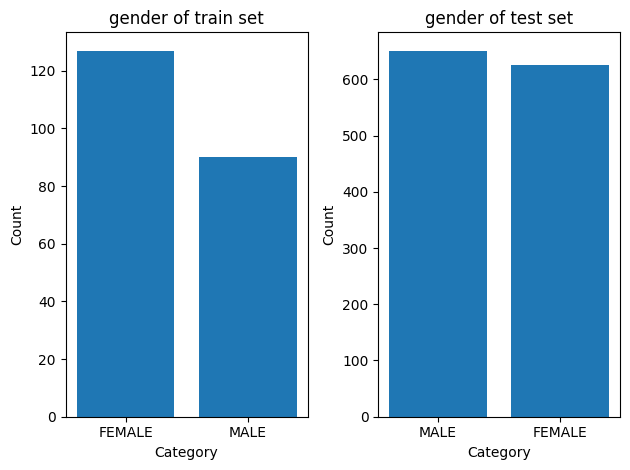

In [26]:
# @title Library: display_str_histogram


def display_single_hist(ax, df, key, title=None):
  series = df[key]
  d = series.value_counts().to_dict()
  ax.bar(list(d.keys()), list(d.values()))
  ax.set_xlabel('Category')
  ax.set_ylabel('Count')
  title = title or f'Histogram of {key}'
  ax.set_title(title)


def display_str_histogram(dfs, key, titles=[]):
  assert len(dfs) < 5, "More than 5 dataframes won't look good"
  if len(dfs) == 1:
    fig, ax = plt.subplots()
    display_single_hist(ax, dfs[0], key, titles[0] if titles else '')
    return
  fig, axes = plt.subplots(1, len(dfs))
  for df, ax, title in zip(dfs, axes, titles):
    series = df[key]
    d = series.value_counts().to_dict()
    ax.bar(list(d.keys()), list(d.values()))
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    title = title or f'Histogram of {key}'
    ax.set_title(title)
  plt.tight_layout()
  plt.show()


display_str_histogram(
    [Globals.df_train, Globals.df_validate],
    'gender',
    titles=['gender of train set', 'gender of test set'],
)

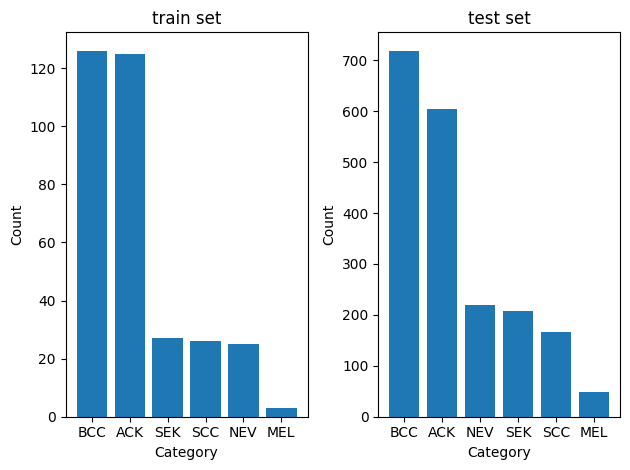

In [27]:
# @title Histogram of 'diagnostic' column values
display_str_histogram(
    [Globals.df_train, Globals.df_validate],
    Globals.label_column,
    titles=['train set', 'test set'],
)

## Train a model

In [28]:
# @title sklearn LogisticRegression model
from sklearn.linear_model import LogisticRegression


def make_dataset(
    df,
    embeddings_map,
    label_key,
    all_categories=Globals.all_col_vals,
    num_samples=None,
):
  """Returns a tuple of (embeddings, int_class_labels) for the given df."""
  embeddings = []
  i = 0
  for _, row in df.iterrows():
    k = row["img_path"]
    embeddings.append(embeddings_map[k])
    if num_samples and i > num_samples:
      break
    i += 1
  int_labels = [
      all_categories.index(x) for x in df[label_key][: len(embeddings)]
  ]
  return embeddings, int_labels


def train_model(df_train, embeddings, label_column=Globals.label_column):
  """Returns a sklearn LogisticRegression model fit to the df_train."""
  train_x, train_y = make_dataset(df_train, embeddings, label_column)
  # https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  model = LogisticRegression(
      penalty="l2",
      solver="saga",
      multi_class="multinomial",
      max_iter=200,
      random_state=Globals.random_state,
  )
  model = model.fit(train_x, train_y)
  return model


Globals.model = train_model(Globals.df_train, Globals.embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Evaluate results

In [29]:
# @title Create `Globals.eval_df`


def get_eval_df(
    df,
    model,
    embeddings=Globals.embeddings,
    label_column=Globals.label_column,
    all_categories=Globals.all_col_vals,
):
  """Runs predict and returns a DataFrame with the predictions."""
  eval_embeddings, eval_labels = make_dataset(df, embeddings, label_column)
  pred = model.predict(eval_embeddings)
  pred_floats = model.predict_proba(eval_embeddings)
  int_labels = lambda col: [all_categories.index(x) for x in col]
  return eval_embeddings, pd.DataFrame({
      'prediction_name': [all_categories[i] for i in pred],
      'prediction': pred,
      'max_prediction_float': [max(p) for p in pred_floats],
      'all_prediction_float': list(pred_floats),
      'groundtruth_name': df[label_column],
      'groundtruth': int_labels(df[label_column]),
  })


eval_embeddings, Globals.eval_df = get_eval_df(
    Globals.df_validate, Globals.model
)
Globals.eval_df

,prediction_name,prediction,max_prediction_float,all_prediction_float,groundtruth_name,groundtruth
0,NEV,3,0.999555,"[6.055725222093297e-08, 4.1554166741317596e-06...",NEV,3
1,BCC,1,0.634764,"[0.14749132407622806, 0.6347639118705889, 3.48...",BCC,1
3,ACK,0,0.926443,"[0.9264429663562049, 0.0028362048537140835, 0....",ACK,0
4,BCC,1,0.859896,"[0.08834036833420178, 0.8598959557604902, 5.71...",BCC,1
5,ACK,0,0.996283,"[0.9962830551849224, 0.0034472985300997303, 3....",SEK,5
...,...,...,...,...,...,...
2292,BCC,1,0.776884,"[0.0011344849346961142, 0.7768844590193713, 1....",SCC,4
2294,BCC,1,0.996511,"[8.042948328144053e-05, 0.996511281162227, 8.6...",BCC,1
2295,SEK,5,0.834360,"[0.00045944484992214936, 3.6543189701975644e-0...",SEK,5
2296,BCC,1,0.998317,"[5.391001913584205e-05, 0.9983168229906619, 1....",BCC,1


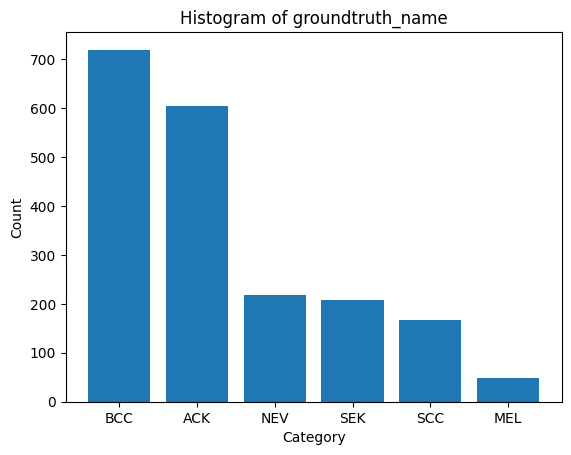

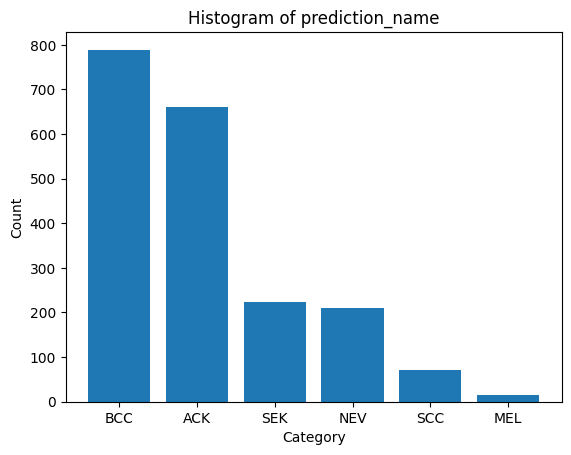

In [30]:
# @title Histogram: prediction vs. label

display_str_histogram([Globals.eval_df], 'groundtruth_name')
display_str_histogram([Globals.eval_df], 'prediction_name')

-- Model used 332 training examples
-- Breakdown by class:
diagnostic
ACK    125
BCC    126
MEL      3
NEV     25
SCC     26
SEK     27
Name: patient_id, dtype: int64
Note that there are very few Melanoma(MEL) examples. It's unlikely the model will learn this concept well unless more examples are provided.
-- Evaluation uses 1966 total examples
-- Histogram of dataset sizes by class:


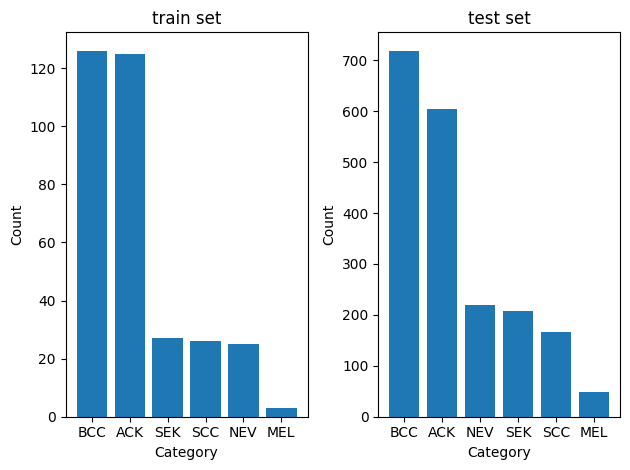

In [31]:
# @title Dataset sizes


def print_data_size():
  """Prints relevant dataset size information to keep in mind."""
  print(f'-- Model used {len(Globals.df_train)} training examples')
  print(f'-- Breakdown by class:')
  agg = Globals.df_train.groupby(by=Globals.label_column)['patient_id'].count()
  print(agg)
  print(
      "Note that there are very few Melanoma(MEL) examples. It's unlikely the "
      'model will learn this concept well unless more examples are provided.'
  )
  print(f'-- Evaluation uses {len(Globals.df_validate)} total examples')
  print('-- Histogram of dataset sizes by class:')
  display_str_histogram(
      [Globals.df_train, Globals.df_validate],
      Globals.label_column,
      titles=['train set', 'test set'],
  )


print_data_size()

In [32]:
# @title Classification report
import sklearn


def get_classification_report(eval_df):
  gt_labels = eval_df[f'groundtruth_name'].values
  pred = eval_df[f'prediction_name'].values
  classification_report = sklearn.metrics.classification_report(
      y_true=gt_labels, y_pred=pred
  )
  print('Classification report:')
  print(classification_report)


get_classification_report(Globals.eval_df)

Classification report:
              precision    recall  f1-score   support

         ACK       0.75      0.82      0.78       605
         BCC       0.74      0.81      0.77       719
         MEL       0.93      0.27      0.41        49
         NEV       0.84      0.81      0.83       219
         SCC       0.39      0.16      0.23       166
         SEK       0.73      0.78      0.75       208

    accuracy                           0.74      1966
   macro avg       0.73      0.61      0.63      1966
weighted avg       0.73      0.74      0.73      1966



In [33]:
# @title Other metrics (cohen kappa, matthews coefficient, log loss)
from sklearn import metrics


def get_other_eval_metrics(eval_df):
  label_names = eval_df[f'groundtruth_name'].values
  label_ints = eval_df[f'groundtruth'].values
  pred_names = eval_df[f'prediction_name'].values
  pred_floats = list(eval_df[f'all_prediction_float'].values)
  predictions = tf.keras.utils.to_categorical(
      eval_df[f'prediction'].values, num_classes=len(Globals.all_col_vals)
  )
  # metrics:
  cohen_kappa = metrics.cohen_kappa_score(
      label_names, pred_names
  )  # target: 0.8
  labels = np.unique(label_names)

  matthews = metrics.matthews_corrcoef(label_names, pred_names)  # target: 0.7
  log_loss = metrics.log_loss(label_ints, pred_floats)  # target: 0
  auc = metrics.roc_auc_score(label_names, predictions, multi_class='ovr',average=None)
  auc_string = []
  for i, label in enumerate(labels):
    auc_string.append(f'{label}: {auc[i]}')
  return {
      'cohen_kappa': cohen_kappa,
      'matthews': matthews,
      'log_loss': log_loss,
      'auc': auc_string
  }


evals = get_other_eval_metrics(Globals.eval_df)

print(json.dumps(evals, indent=4))

{
    "cohen_kappa": 0.6425307412438236,
    "matthews": 0.6449280531777553,
    "log_loss": 0.9333319982267354,
    "auc": [
        "ACK: 0.8484737158506447",
        "BCC: 0.8239223371139414",
        "MEL: 0.6323922370200036",
        "NEV: 0.8946648265911817",
        "SCC: 0.5693808567603749",
        "SEK: 0.8720738163997549"
    ]
}


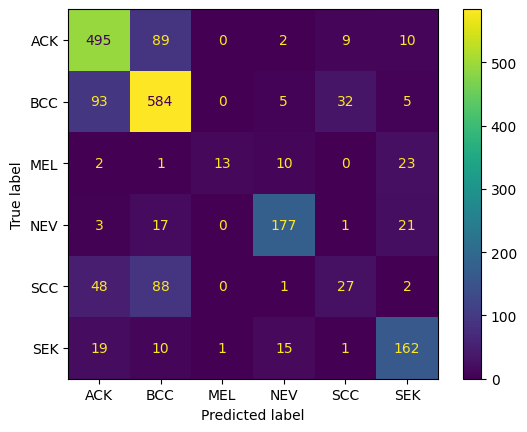

In [34]:
# @title Confusion matrix
from sklearn import metrics


def make_confusion_matrix(df, groundtruth_field, prediction_field):
  gt_labels = df[groundtruth_field].values
  predictions = df[prediction_field].values
  cm = metrics.confusion_matrix(gt_labels, predictions)
  cm_display = metrics.ConfusionMatrixDisplay(
      cm, display_labels=Globals.all_col_vals
  )
  cm_display.plot()
  plt.show()


make_confusion_matrix(
    Globals.eval_df,
    'groundtruth',
    'prediction',
)

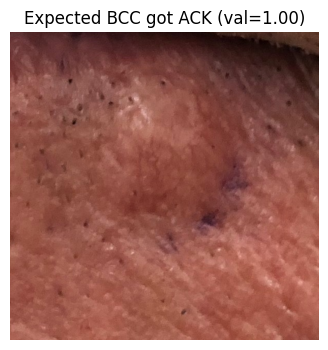

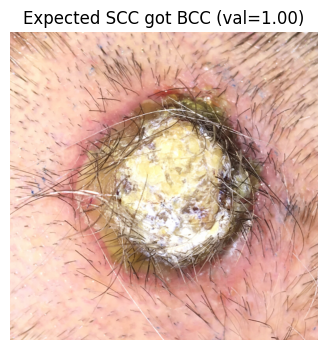

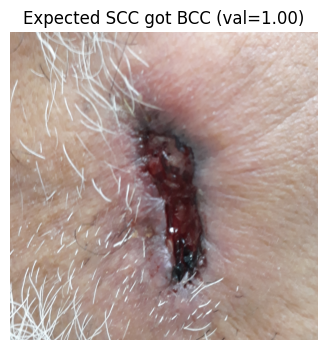

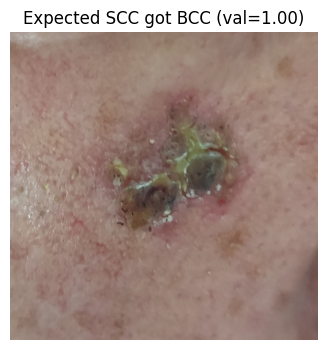

,index,prediction_name,prediction,max_prediction_float,all_prediction_float,groundtruth_name,groundtruth,index,patient_id,lesion_id,...,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,img_path
748,847,ACK,0,0.999954,"[0.9999540116292196, 7.748168970217891e-06, 1....",BCC,1,847,PAT_16,24,...,BCC,False,UNK,False,UNK,False,True,PAT_16_24_691.png,True,pad_dataset/images/PAT_16_24_691.png
573,657,BCC,1,0.999916,"[2.1082518250728606e-05, 0.9999163998036593, 6...",SCC,4,657,PAT_219,336,...,SCC,True,UNK,False,UNK,False,True,PAT_219_336_376.png,True,pad_dataset/images/PAT_219_336_376.png
336,382,BCC,1,0.999713,"[8.690988219839686e-06, 0.9997133729447654, 2....",SCC,4,382,PAT_770,1451,...,SCC,True,True,True,False,True,True,PAT_770_1451_136.png,True,pad_dataset/images/PAT_770_1451_136.png
1615,1881,BCC,1,0.999489,"[2.1335959355238444e-05, 0.9994892141086108, 2...",SCC,4,1881,PAT_686,1355,...,SCC,True,True,True,True,True,True,PAT_686_1355_168.png,True,pad_dataset/images/PAT_686_1355_168.png
1914,2237,ACK,0,0.999447,"[0.9994466622474388, 0.00014420942869045451, 4...",BCC,1,2237,PAT_30,41,...,BCC,True,UNK,False,UNK,False,False,PAT_30_41_815.png,True,pad_dataset/images/PAT_30_41_815.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1410,SCC,4,0.392099,"[0.3420374440891026, 0.26559903352218867, 0.00...",BCC,1,1410,PAT_823,1558,...,BCC,True,True,True,False,True,True,PAT_823_1558_870.png,True,pad_dataset/images/PAT_823_1558_870.png
1862,2174,SEK,5,0.381726,"[0.012373818360236233, 0.33277483438069094, 0....",NEV,3,2174,PAT_1216,759,...,NEV,False,True,False,False,False,True,PAT_1216_759_365.png,False,pad_dataset/images/PAT_1216_759_365.png
788,896,NEV,3,0.364957,"[0.27210724014386545, 0.13626791335717384, 0.0...",ACK,0,896,PAT_862,1643,...,ACK,True,True,False,False,False,False,PAT_862_1643_386.png,True,pad_dataset/images/PAT_862_1643_386.png
1674,1946,SEK,5,0.345166,"[0.034677140535551605, 0.30538627092435355, 0....",NEV,3,1946,PAT_417,828,...,NEV,False,True,False,False,False,True,PAT_417_828_723.png,True,pad_dataset/images/PAT_417_828_723.png


In [35]:
# @title Display model failures
# These are examples that the model returned high confidence for a prediction
# class different from the groundtruth.
def display_failure(num_images=4):
  # Combine the eval_df and the validation DataFrame
  df = pd.concat(
      [Globals.eval_df.reset_index(), Globals.df_validate.reset_index()], axis=1
  )
  assert list(df['groundtruth_name']) == list(
      df['diagnostic']
  ), f'Concatenated data has a bug - two columns that should match do not :('
  # Get the rows where the prediction was incorrect
  df = df[df['prediction_name'] != df['groundtruth_name']]
  df = df.sort_values(by='max_prediction_float', ascending=False)
  for i in range(num_images):
    row = df.iloc[i]
    img_path = row['img_path']
    gt = row['groundtruth_name']
    p = row['prediction_name']
    val = row['max_prediction_float']
    display_image(
        Globals.gcs_bucket,
        img_path,
        title=f'Expected {gt} got {p} (val={val:.2f})',
    )
  return df


display_failure()

### Review stats by Fitzpatrick Skin Type

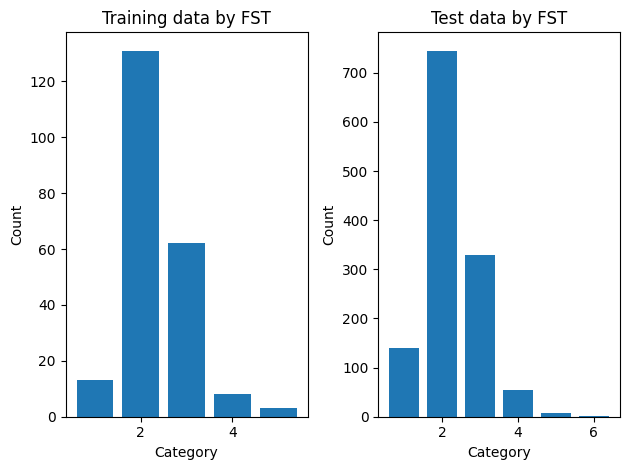

In [36]:
# Note: This dataset has very small sample sizes of FST5-6 skin types.
display_str_histogram(
    [Globals.df_train, Globals.df_validate],
    "fitspatrick",
    titles=["Training data by FST", "Test data by FST"],
)

In [37]:
def check_accuracy_by_fitzpatrick():
  """Returns a DataFrame with accuracy by FST category."""
  df = pd.concat(
      [Globals.eval_df.reset_index(), Globals.df_validate.reset_index()], axis=1
  )
  assert list(df['groundtruth_name']) == list(
      df['diagnostic']
  ), f'Concatenated data has a bug - two columns that should match do not :('
  df['correct'] = df.apply(
      lambda row: 1
      if (row['prediction_name'] == row['groundtruth_name'])
      else 0,
      axis=1,
  )
  df['row_has_val'] = df.apply(lambda row: 1, axis=1)
  df = df.groupby('fitspatrick')[['correct', 'row_has_val']].sum().reset_index()
  df['percentage'] = df['correct'] / df['row_has_val']
  return df


check_accuracy_by_fitzpatrick()

,fitspatrick,correct,row_has_val,percentage
0,1.0,96,140,0.685714
1,2.0,500,745,0.671141
2,3.0,225,330,0.681818
3,4.0,39,54,0.722222
4,5.0,4,7,0.571429
5,6.0,1,1,1.000000
